# Iterative closest point
More details: https://en.wikipedia.org/wiki/Iterative_closest_point

In [24]:
# Import all the necessary toolbox for basic python development 
from simpleicp import PointCloud, SimpleICP
import numpy as np
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import spatialmath
import scipy
import sys 
from sklearn.neighbors import NearestNeighbors
from spatialmath import *
from spatialmath.base import *
from scipy.spatial.transform import Rotation as R
from scipy.linalg import eigh

%matplotlib widget  


In [25]:
# Read point clouds from xyz files into n-by-3 numpy arrays
X_fix = np.genfromtxt("bunny_part1.xyz")

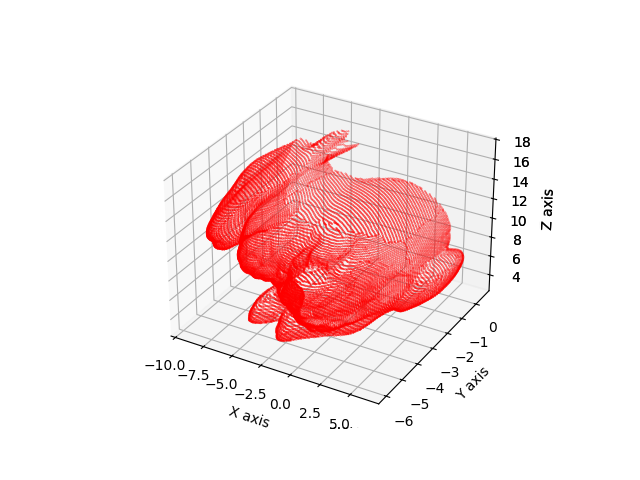

(20702, 3)


In [26]:
# Plot the cloud point X_fix
fig = plt.figure(1)      #create the figure
ax = fig.add_subplot(111, projection='3d')      #setup the 3D space

# Add the point to the figure
ax.scatter(X_fix[:, 0], X_fix[:, 1], X_fix[:, 2], c='r', marker='.', s=0.5)   
    

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# Show the graph
plt.show(fig)

print(X_fix.shape)

In [27]:
# Build a transformation matrix with a translation of: 
# 2 along x, 
# 6 along y, 
# 0 along z
# and a rotation of:
# 15 degrees around z
# 20 degrees around x

translation = SE3(2,6,0)

rotation_x = SE3.Rx(20, unit='deg')

rotation_z = SE3.Rz(15, unit='deg')

T1 = translation * rotation_x*rotation_z
# Print the matrix T1
print(T1) 

   0.9659   -0.2588    0         2         
   0.2432    0.9077   -0.342     6         
   0.08852   0.3304    0.9397    0         
   0         0         0         1         



In [28]:
# Create P_source which is equal to X_fix but transposed and with the homogenoues component 
P_source = np.zeros((4, 20702))
P_source[0,:] = X_fix[:,0]
P_source[1,:] = X_fix[:,1]
P_source[2,:] = X_fix[:,2]
P_source[3,:] = 1

# Multiply T1 and P_source to obtain P_end (end point cloud) 
P_end = np.dot(T1, P_source)

# Exctract the array of points transposed back and without the homogenous component
PB = np.zeros((20702,3))
PB[:,0] = P_end[0,:]
PB[:,1] = P_end[1,:]
PB[:,2] = P_end[2,:]

print(P_end.shape)
print(PB.shape)

# Save PB into the variable X_mov
X_mov = PB
# Add some withe noise, impost the noise variable equal to 100 
mean_noise = 100
# In this way we add the random withe noise to our data
transf_points = PB + mean_noise * np.random.randn(*PB.shape)

# Traspose the array
transf_points_T = transf_points.T

# Sort the rows
transf_points_sorted = transf_points_T[np.argsort(transf_points_T[:, 0])]

# Transpose back
transf_points = transf_points.T


(4, 20702)
(20702, 3)


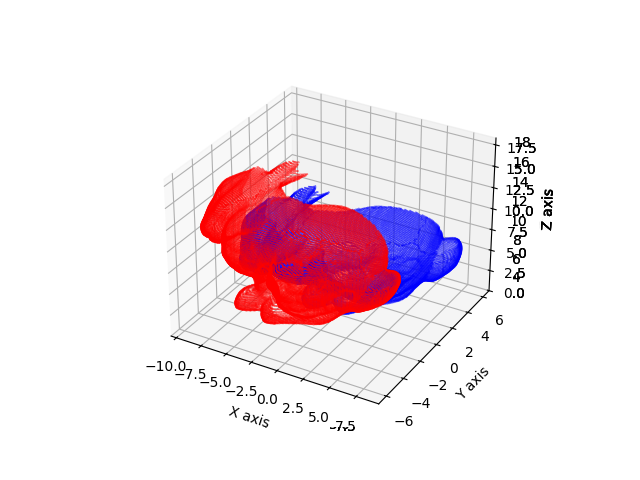

In [29]:
# Plot the two cloud points X_fix and X_mov
fig = plt.figure(2)      #create the figure
ax = fig.add_subplot(111, projection='3d')      #setup the 3D space

# Add the point to the figure
ax.scatter(X_fix[:, 0], X_fix[:, 1], X_fix[:, 2], c='r', marker='.', s=0.5)   
ax.scatter(X_mov[:, 0], X_mov[:, 1], X_mov[:, 2], c='b', marker='.', s=0.5) 

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# Show the graph
plt.show(fig)

In [30]:
# Create point cloud objects
pc_fix = PointCloud(X_fix, columns=["x", "y", "z"])
pc_mov = PointCloud(X_mov, columns=["x", "y", "z"])

# Create simpleICP object, add point clouds, and run algorithm!
icp = SimpleICP()
icp.add_point_clouds(pc_fix, pc_mov)
H, X_mov_transformed, rigid_body_transformation_params, distance_residuals = icp.run(max_overlap_distance=50)

Consider partial overlap of point clouds ...
Select points for correspondences in fixed point cloud ...
Estimate normals of selected points ...
Start iterations ...
iteration | correspondences | mean(residuals) |  std(residuals)
   orig:0 |             974 |          0.0751 |          1.5007
        1 |             973 |          0.0861 |          1.1091
        2 |             856 |          0.0405 |          0.6000
        3 |             882 |          0.0398 |          0.5584
        4 |             877 |          0.0245 |          0.4855
        5 |             887 |          0.0083 |          0.4250
        6 |             881 |          0.0014 |          0.3541
        7 |             884 |         -0.0067 |          0.3072
        8 |             903 |         -0.0087 |          0.2731
        9 |             887 |         -0.0092 |          0.2271
       10 |             862 |         -0.0005 |          0.1870
       11 |             849 |         -0.0016 |          0.1453
   

In [31]:
# Print the two matrixes and compare the estimated one with the original one
print(T1)
print(transf_points)

   0.9659   -0.2588    0         2         
   0.2432    0.9077   -0.342     6         
   0.08852   0.3304    0.9397    0         
   0         0         0         1         

[[ -45.4812696    19.95611568 -107.77466827 ... -120.70363153
    90.84233431   -7.09524542]
 [ -24.44247309  -25.88656907  -91.06686957 ...  -61.71139968
   122.11893051  -37.75056246]
 [  51.32801494 -132.12762765  -51.97886257 ...  -42.45026414
    87.22557024  108.48490755]]


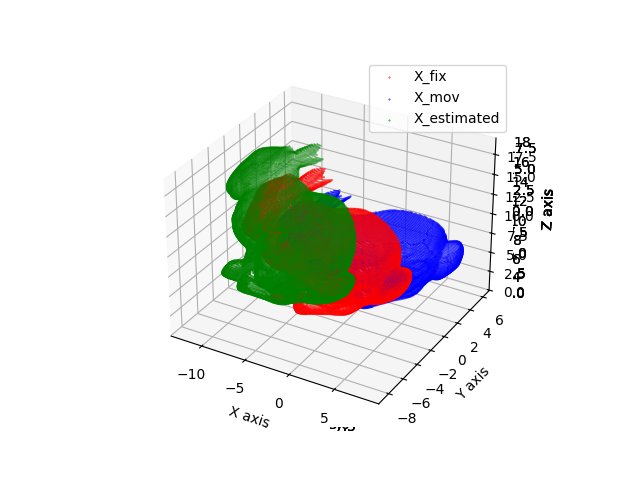

In [37]:
# Homework: #TODO
# Compute X_estimated multiplying the estimated transformation matrix H with the original cloud point X_fix
# Plot the three cloud points (X_fix, X_mov, X_estimated) and check if the transformation was successfully estimated

# Multiply T1 and P_source to obtain P_end (end point cloud) 
X_estimated_homogenous = np.dot(H, P_source)

# Exctract the array of points transposed back and without the homogenous component
X_estimated = np.zeros((20702,3))
X_estimated[:,0] = X_estimated_homogenous[0,:]
X_estimated[:,1] = X_estimated_homogenous[1,:]
X_estimated[:,2] = X_estimated_homogenous[2,:]

# Plot the three cloud points X_fix, X_mov, and X_estimated
fig = plt.figure(2)  # create the figure
ax = fig.add_subplot(111, projection='3d')  # setup the 3D space

# Add the points to the figure
ax.scatter(X_fix[:, 0], X_fix[:, 1], X_fix[:, 2], c='r', marker='.', s=0.5, label='X_fix')   
ax.scatter(X_mov[:, 0], X_mov[:, 1], X_mov[:, 2], c='b', marker='.', s=0.5, label='X_mov') 
ax.scatter(X_estimated[:, 0], X_estimated[:, 1], X_estimated[:, 2], c='g', marker='.', s=0.5, label='X_estimated') 

# Add labels and legend
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.legend()  # Display the legend

# Show the graph
plt.show(fig)


### More about this algorithm: https://github.com/pglira/simpleICP